Melanoma image classification
Melanoma, also known as malignant melanoma, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members and poor immune function are at greater risk. A number of rare genetic conditions such as xeroderma pigmentosum also increase the risk. Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.

Using sunscreen and avoiding UV light may prevent melanoma. Treatment is typically removal by surgery In those with slightly larger cancers, nearby lymph nodes may be tested for spread (metastasis). Most people are cured if spread has not occurred. For those in whom melanoma has spread, immunotherapy, biologic therapy, radiation therapy or chemotherapy may improve survival.With treatment, the five-year survival rates in the United States are 99% among those with localized disease, 65% when the disease has spread to lymph nodes and 25% among those with distant spread.The likelihood that melanoma will reoccur or spread depends on its thickness, how fast the cells are dividing and whether or not the overlying skin has broken down.

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, there were 3.1 million people with active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. There are also high rates in Northern Europe and North America, while it is less common in Asia, Africa and Latin America. In the United States melanoma occurs about 1.6 times more often in men than women.Melanoma has become more common since the 1960s in areas mostly populated by people of European descent.

In this competition given an image of the potential cancer we are asked to predict whether it's beingn or malignant.

In our case we are dealing with lesion images and it becomes all the more necessary to be able to **interpret** the model.
Attention is arguably one of the most powerful concepts in the deep learning field nowadays. It is based on a common-sensical intuition that we “attend to” a certain part when processing a large amount of information.
For Basic information regarding Attention with CNN :

https://www.youtube.com/watch?v=W2rWgXJBZhU



Model architecture is based on the follwing paper :

https://www2.cs.sfu.ca/~hamarneh/ecopy/ipmi2019.pdf

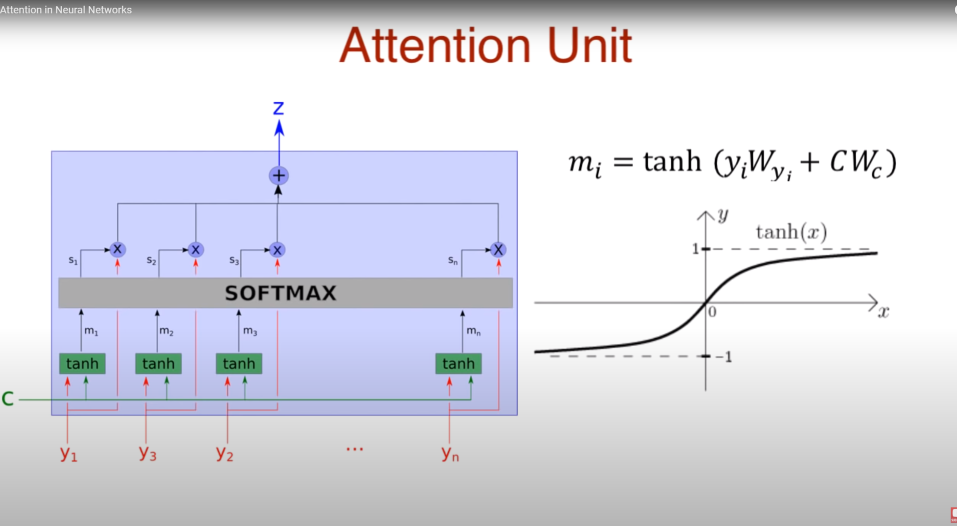

# Imports

In [ ]:
#conda install -c pytorch torchvision cudatoolkit=10.1 pytorch

In [ ]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import cv2

import os
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from sklearn.metrics import auc,roc_auc_score
import time
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, models
import torchvision.utils as utils
device = torch.device("cpu")

import warnings
warnings.filterwarnings("ignore")

This function choose known seed -which gives reproductibility of results 

seed - Number of the seed to use

In [ ]:
def seed_everything(seed):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(7)

function to convert image path to file + add label to image

In [ ]:
class ImageDataset(Dataset):
    
    def __init__(self,data_paths,labels,transform=None,mode='train'):
         self.data=data_paths
         self.labels=labels
         self.transform=transform
         self.mode=mode
    def __len__(self):
       return len(self.data)
    
    def __getitem__(self,idx):
        img_name = self.data[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=Image.fromarray(img)
        if self.transform is not None:
          img = self.transform(img)
        img=img.cuda()
        
        if self.mode=='test':
            return img,img_name
        else:
           
            labels = torch.tensor(self.labels[idx]).cuda()

            return img, labels

FAIR proposes a new loss function that focuses a neural networks attention on the instances where it predicted the wrong class. Instead of trying to reduce outliers or predictions where the model’s prediction is far off from the truth, Focal Loss reduces the weight (or impact) the values it predicted correctly carry. The loss function is just a mathematical way of saying how far off a guess is from the real value of a datapoint. Frequently used in computer vision is the Cross Entropy Loss, which the Focal loss adds probability-dependent weight to CE loss.
I'll use FL instead regular Binary Cross-Entropy loss dince Dataset is Imbalanced and FL can automatically down-weight easy samples in training set.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.2, gamma=1.3, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# VGG16 Model with attention

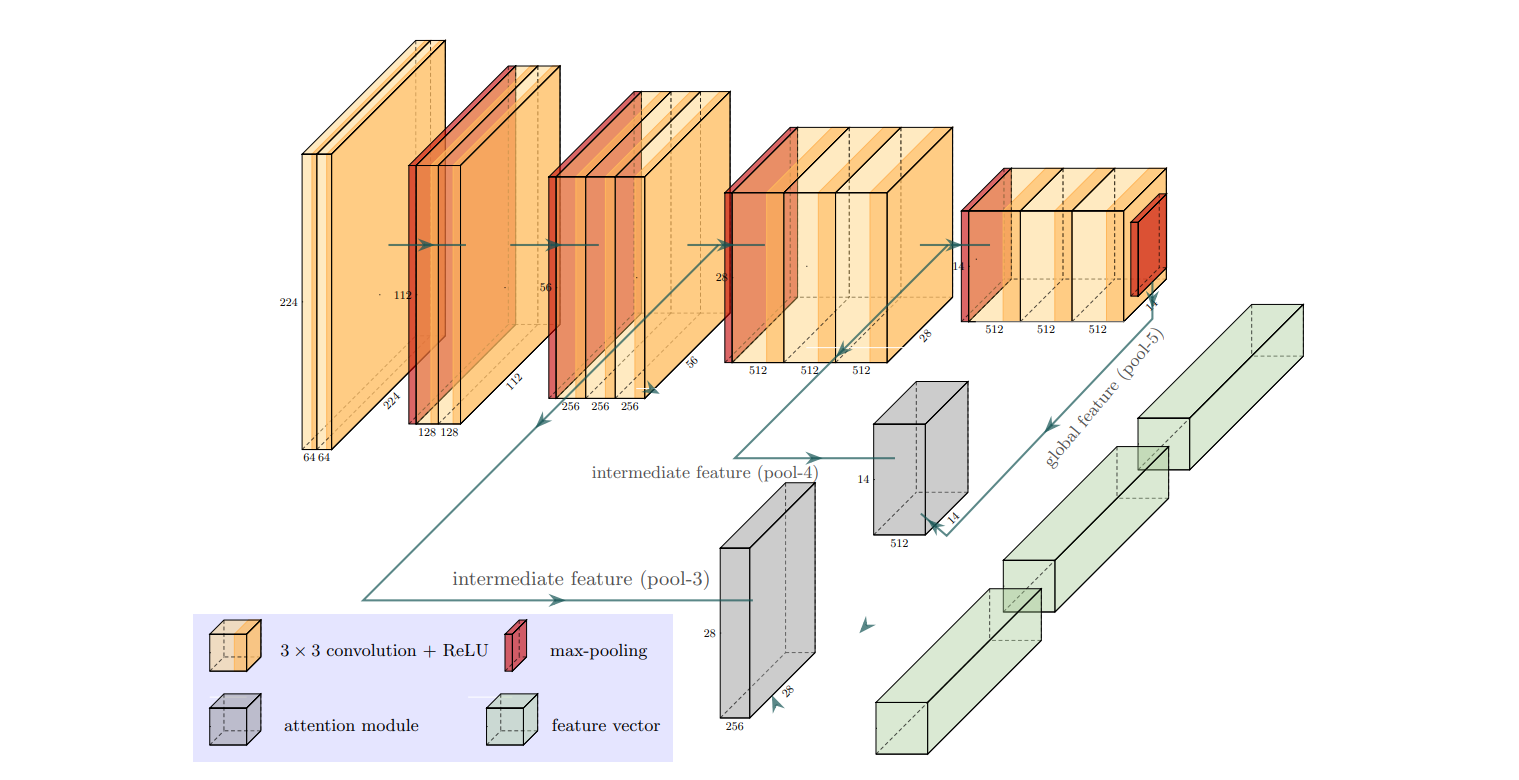

 The overall network architecture. The backbone network is VGG-16 (the yellow and red blocks) without any dense layers. Two attention modules  are applied (the gray blocks). The three feature vectors (green blocks) are computed via global average pooling and are concatenated together to form the final feature vector, which serves as the input to the classification layer. The classification layer is not shown here.

The architecture of VGG16 is kept mostly the same except the Dense layers are removed
The whole network is trained end-to-end
The shallower layer (pool-3) tends to focus on more general and diffused areas, while the deeper layer (pool-4) is more concentrated, focusing on the lesion and avoiding irrelevant objects.
 But since most images in our case are benign, pool-3 tries to learn some areas but pool-4 eventually minimizes the activated regions because the image is benign.

In [ ]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)
        
       
        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()
        
        g = self.pool(pool5).view(N,512)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

# Attention Block

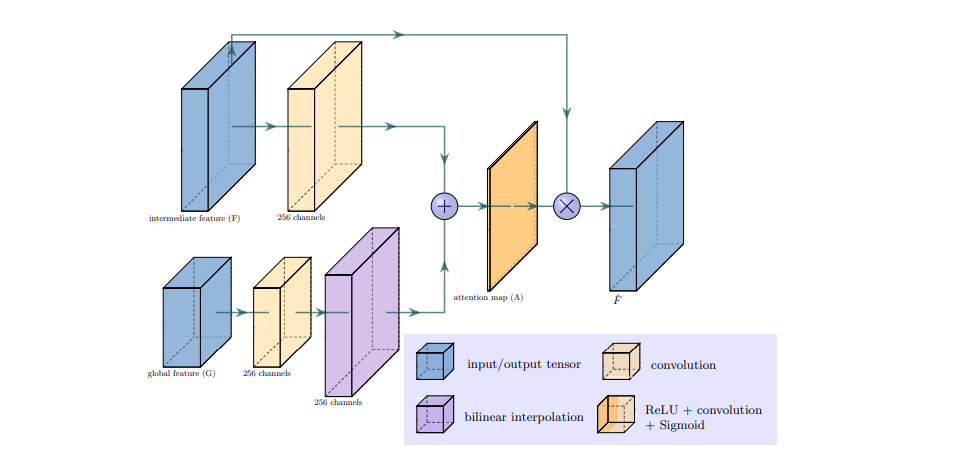

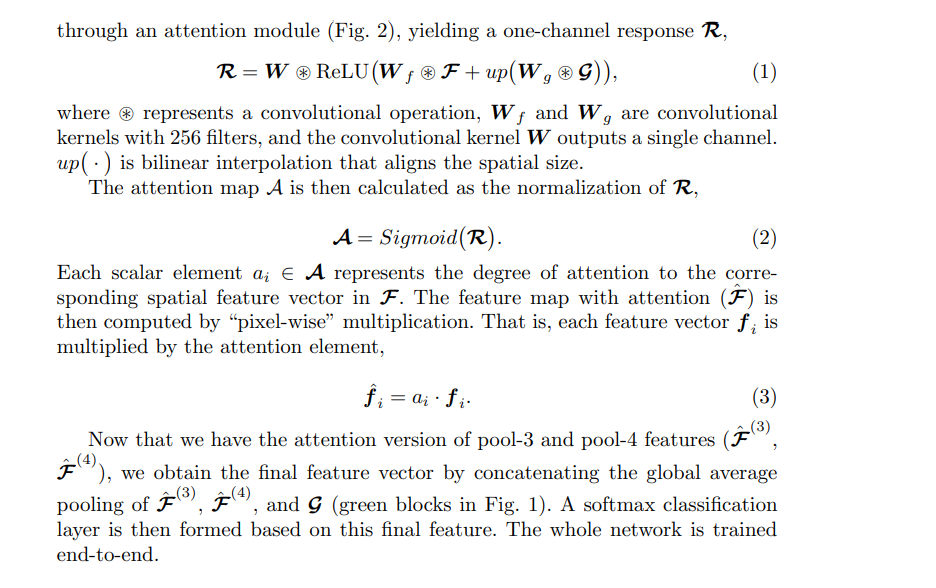

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

    

# Define Train & Test dir

In [ ]:
train_dir='../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('../input/melanoma-merged-external-data-512x512-jpeg/marking.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

## Data Pre-processing 

In the follwing kernel -we have simple example how to deal with the data
https://www.kaggle.com/dormann/melanoma-image-classification

To tackle Unbalanced dataset problem you should try to balance your dataset, either by over-sampling minority classes or under-sampling majority classes (or both). Arguably, a good choice would be SMOTE (Synthetic Minority Over-sampling Technique) algorithm, as mentioned above. Here you can find a comparison of different over-sampling algorithms. If you're a Python user, imbalanced-learn is a nice library that implements many useful techniques for balancing datasets.

On the other hand, if you're trying to classify images, a nice way to increase your dataset size is to augment it (i.e. by creating reasonable synthetic examples, e.g. similar images but rotated/shifted tiny bit with respect to original ones). You might sometimes find it useful to augment the minority classes to achieve better balance. Keras ImageDataGenerator class is a good tool for this purpose.
We’ll also :

0.Under sample
1. Resize & normalize train and test datasets.
2.Data augmentation on train images.


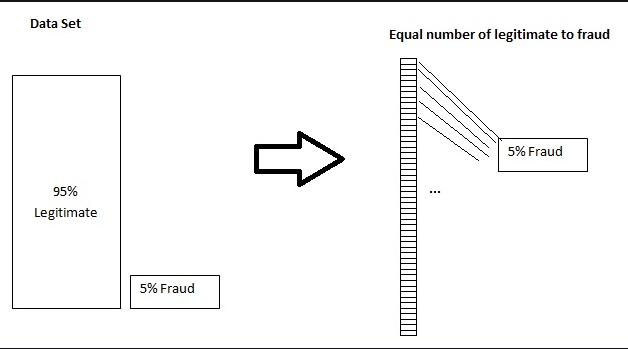

In [ ]:
# balance the data a bit
df_0=train[train['target']==0].sample(4000,random_state=42)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

In [ ]:
#prepare train data
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_id'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

#Prepare test data

test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.25, random_state=7)

# Data augmentation

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# Create loader to use on attention model

In [ ]:
train_dataset=ImageDataset(data_paths=X_train.values,labels=y_train.values,transform=train_transform)
val_dataset=ImageDataset(data_paths=X_val.values,labels=y_val.values,transform=test_transform)
test_dataset=ImageDataset(data_paths=df_test['images'].values,labels=None,transform=test_transform,mode='test')

train_loader=DataLoader(train_dataset,batch_size=100,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=50,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=50,shuffle=False)

In [ ]:
model = AttnVGG(num_classes=1, normalize_attn=True)
model=model.cuda()

In [ ]:
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=0.01)


Sweep on epochs

In [ ]:
start_time = time.time()

epochs = 15

train_losses = []
test_losses = []
train_auc=[]
val_auc=[]

for i in range(epochs):

    train_preds=[]
    train_targets=[]
    auc_train=[]
    loss_epoch_train=[]
    loss_epoch_test=[]
    # Run the training batches
    for b, (X_train, y_train) in tqdm(enumerate(train_loader),total=len(train_loader)):
        
        b+=1
        y_pred,_,_=model(X_train)
        loss = criterion(torch.sigmoid(y_pred.type(torch.FloatTensor)), y_train.type(torch.FloatTensor))   
        loss_epoch_train.append(loss.item())
        # For plotting purpose
        if (i==1):
            if (b==19):
                I_train = utils.make_grid(X_train[0:8,:,:,:], nrow=8, normalize=True, scale_each=True)
                __, a1, a2 = model(X_train[0:8,:,:,:])
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

                 
    try:
        auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
    except:
        auc_train=0
    train_losses.append(np.mean(loss_epoch_train))
    train_auc.append(auc_train)
    print(f'epoch: {i:2}   loss: {np.mean(loss_epoch_train):10.8f} AUC  : {auc_train:10.8f} ')
    # Run the testing batches
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            
            y_val,_,_ = model(X_test)
            loss = criterion(torch.sigmoid(y_val.type(torch.FloatTensor)), y_test.type(torch.FloatTensor))
            loss_epoch_test.append(loss.item())
    try:
                                           
        auc_val=roc_auc_score(y_test.detach().to(device).numpy(),torch.sigmoid(y_val).detach().to(device).numpy())
    except:
        auc_val=0
    test_losses.append(np.mean(loss_epoch_test))
    val_auc.append(auc_val)
    print(f'Epoch: {i} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

## Visualizing Attention
Now let's visualize the attention maps created by pool-3 and pool-4 to understand which part of the image are responsible for the classification.

In [ ]:
def visualize_attention(I_train,a,up_factor,no_attention=False):
    img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    img=cv2.resize(img,(466,60))
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)
        

In [ ]:
orig=visualize_attention(I_train,a1,up_factor=2,no_attention=True)
first=visualize_attention(I_train,a1,up_factor=2,no_attention=False)
second=visualize_attention(I_train,a2,up_factor=4,no_attention=False)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(10, 10))
ax1.imshow(orig)
ax2.imshow(first)
ax3.imshow(second)
ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')

### Reference

* https://github.com/SaoYan/IPMI2019-AttnMel/tree/99e4a9b71717fb51f24d7994948b6a0e76bb8d58

